<a href="https://colab.research.google.com/github/AminaTkh/AlanTuringInstitute_Bias_in_AI/blob/main/Forms-and-Quantification-of-Bias-in-AI/Practice_4_Example_code_get_a_confidence_interval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Milestone 3: Sources, Forms, and Quantification of Bias and Discrimination in Supervised Learning**
## **PRACTICE NOTEBOOK 4 - Example code to get confidence intervals for a metric**


In this part of the course, we will look for bias using a practical example. A  company is looking to hire a new employee. They use a machine learning algorithm to select the top candidates. The candidates are assigned either 0 if they're not selected or 1 if they are.

There are 4 practice notebooks in total (current one in red):
1. Explore given data to: detect potential bias early & check for proxies
2. Evaluate model bias "manually"
3. Evaluate model bias using **holisticai** library
4. <font color='red'> **Example code to get confidence intervals for a metric**</font>

Instructions to complete in each parts are in bold. Intermediate results are given so one can continue the exercise.

This is notebook number 4. As stated at the end of the previous notebook, so far, we only obtained one number for fairness metrics. In a real life setting, you should calculate a confidence interval by repeating the experiments for different train/test splits. A way to do this is for instance to use a non-parametric bootstrap method as described in section 10.2 from the book [Computer Age Statistical Inference by B.Efron and T.Hastie](https://web.stanford.edu/~hastie/CASI_files/PDF/casi.pdf) that we linked earlier. We give an example of this in the next and last notebook. Note that there will be nothing for you to do in this last notebook.

## **0. Import modules, load data and useful functions**

In [1]:
# install holisticai
!pip3 install holisticai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.4/241.4 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 14.8 MB/s eta 0:00:00


In [2]:
# imports
import pickle
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier

from holisticai.bias.metrics import *

In [3]:
# Load data

from sklearn.datasets import fetch_openml
bunch = fetch_openml(data_id=44270)
raw_data = bunch['frame']
raw_data

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


,Label,Gender,Ethnicity,0,1,2,3,4,5,6,...,40,41,42,43,44,45,46,47,48,49
0,1,Female,Black,-0.178832,0.147077,0.775331,-0.427889,0.640818,-0.610427,-1.023371,...,0.513206,-0.042387,-0.355889,-0.465837,-2.832634,0.917297,-0.241052,-2.122105,0.253170,0.164617
1,1,Male,Hispanic,0.092276,0.122023,0.482935,-0.232131,-1.939064,-1.140216,-0.833250,...,-1.203151,0.750136,-1.417751,1.254152,0.631731,1.665469,-0.388293,-0.804782,-0.227182,0.412375
2,0,Female,Hispanic,-1.703377,-0.962149,-0.785495,-0.633902,-0.334718,-1.555958,0.825006,...,0.249654,0.368800,0.079523,-0.932425,-0.693293,-0.114197,-1.252067,0.834270,-0.463270,0.559294
3,0,None,None,-1.229715,-1.342997,-0.093382,0.136900,1.195076,-0.582687,0.052355,...,0.667730,0.595494,0.454502,-0.366884,-0.399758,1.113102,0.126707,0.474569,-0.158103,1.197710
4,1,Male,Hispanic,-0.363013,1.264307,1.667603,0.903941,-0.062840,0.680886,0.389930,...,-0.494161,0.784050,-0.311236,2.447118,1.127650,0.086733,-0.381553,0.209684,0.197809,-0.879914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,Female,Hispanic,-0.057075,1.791513,-1.065756,-0.783341,-0.559215,1.042646,-1.154058,...,-0.335082,0.709753,0.021583,1.718576,1.171804,0.430075,3.340726,1.349216,1.481516,0.070563
9996,1,Male,Black,0.582066,0.086788,0.167259,-1.672798,1.537135,-1.113315,0.222907,...,-0.562594,0.150314,-0.072920,-1.841719,-0.807065,-0.793955,-1.098300,-1.474154,-0.828826,-0.891166
9997,0,Male,White,-1.355098,-0.321228,-0.204290,0.498632,1.634130,0.847070,-0.552140,...,-1.204719,0.688433,-1.781911,0.275032,0.690859,0.666878,0.644440,0.127891,1.277781,-0.744428
9998,1,Male,White,-0.526557,2.174463,-0.979082,-0.681536,-0.145515,1.703135,0.947010,...,-0.487367,2.043764,-1.570147,0.861712,-0.939181,0.090775,-1.153183,-1.362903,-1.424866,-0.374579


In [4]:
# remove all nans --> we use the variable "data" in the rest of this notebook
data = raw_data.dropna()

In [5]:
def split_data_from_df(data):
  y = data['Label'].values
  # g = data['Gender'].values
  # e = data['Ethnicity'].values
  X = data[np.arange(50).astype(str)].values
  filter_col = ['Ethnicity','Gender'] + [col for col in data if str(col).startswith('Ethnicity_')] + [col for col in data if str(col).startswith('Gender_')]
  dem = data[filter_col].copy()
  return X,y,dem

def encode(df):
  g_enc = LabelEncoder()
  e_enc = LabelEncoder()
  df['Gender'] = g_enc.fit_transform(df['Gender'])
  df['Ethnicity'] = e_enc.fit_transform(df['Ethnicity'])
  return df, g_enc,e_enc

X,y,dem = split_data_from_df(data)

dem

,Ethnicity,Gender
0,Black,Female
1,Hispanic,Male
2,Hispanic,Female
4,Hispanic,Male
5,Black,Male
...,...,...
9994,Asian,Male
9995,Hispanic,Female
9996,Black,Male
9997,White,Male


## **2. An example using non-parametric bootstrap to get a confidence interval**

Let's demonstrate how we can get a confidence interval for metrics using bootstrap sampling in this section. All the code is provided and there is nothing to do.

The steps are:

1. We define two helper functions that calculate performance and fairness metrics.
2. We define the number of iterations (100 here), the unprivileged and privileged groups (Black vs White)
3. For each iteration we:
 - create a bootstrap sample of the data (sample the data with replacement). This sample is used as training data. Because we sample with replacement, some original data points will be present several times and some will not be there at all. As a rule of thumb, about a third of the original data is not selected. We use this as the test set to evaluate metrics.
  - calculate the performance and fairness metrics using the pre-defined functions.
4. We then display the mean and standard deviation for each metric, and plot an histogram for Disparate Impact
A 90% confidence interval can be for instance obtained by using the 5th and 95th percentiles of the obtained values as the lower and upper limits.

In [6]:
import sklearn.metrics as metrics
from tqdm.notebook import tqdm

def get_perf_metrics(y_true,y_pred):
    # setup the performance metrics to be computed
    perf_metrics = {"Accuracy": metrics.accuracy_score(y_true,y_pred),
                "Precision": metrics.precision_score(y_true,y_pred),
                "Recall": metrics.recall_score(y_true,y_pred),
                "F1-Score": metrics.f1_score(y_true,y_pred),
                }
    met = []
    for pf in perf_metrics.keys():
            met += [[pf, perf_metrics[pf]]]

    df = pd.DataFrame(met, columns=["Metric", "Value"])
    return df

def get_fair_metrics(df_data,y_pred,privileged_groups,unprivileged_groups):
    X_data,y_data,dem_data = split_data_from_df(df_data)

    # get metrics of interest
    group_a = dem_data.Ethnicity==1
    group_b = dem_data.Ethnicity==3

    met = []
    met += [['Statistical Parity Difference', statistical_parity(group_a, group_b, y_pred)]]
    met += [['Disparate Impact', disparate_impact(group_a, group_b, y_pred)]]
    met += [['Equal Opportunity Difference (True Positive Rate Difference)', equal_opportunity_diff(group_a, group_b, y_pred, y_data)]]
    met += [['False Positive Rate Difference', false_positive_rate_diff(group_a, group_b, y_pred, y_data)]]
    met += [['Average Odds Difference', average_odds_diff(group_a, group_b, y_pred, y_data)]]
    df = pd.DataFrame(met, columns=["Metric", "Value"])
    return df

In [7]:
# settings
n_iter = 100
unprivileged_groups = 1  #1 is the code for 'Black'
privileged_groups = 3   #3 is the code for 'White
# make Gender and Ethnicity numerical
data_enc,_,_ = encode(data.copy())
#loop
for i in tqdm(range(n_iter)):
    # sample with replacement
    idx_bootsample = np.random.choice(range(len(data)), size=len(data), replace=True)
    df_train = data_enc.iloc[idx_bootsample].copy()
    X_train,y_train,_ = split_data_from_df(df_train)
    # train on bootsample
    model = RidgeClassifier()
    model.fit(X_train,y_train)
    # test on remaining indexes (not selected by bootsample ~ 1/3 of total)
    idx_test = np.array([i for i in range(len(data)) if i not in idx_bootsample])
    df_test = data_enc.iloc[idx_test].copy()
    X_test,y_test,_ = split_data_from_df(df_test)
        # predict on test set
    y_pred_test = model.predict(X_test)
        # get perf metrics
    met_perf = get_perf_metrics(y_test,y_pred_test)
        # get fairness metrics
    met_fair = get_fair_metrics(df_test,y_pred_test,privileged_groups,unprivileged_groups)
    # concatenate all results in one dataframe
    met= pd.concat([met_perf, met_fair], axis=0, ignore_index=True)
    met['Iteration'] = i
    if i==0:
        df_metrics = met.copy()
    else:
        df_metrics = pd.concat([df_metrics, met.copy()], axis=0, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [8]:
# Display metrics
metrics_table = df_metrics.pivot_table(index="Metric", values="Value", aggfunc=["mean", "std"])
metrics_table

,mean,std
,Value,Value
Metric,,
Accuracy,0.706540,0.007115
Average Odds Difference,-0.077080,0.021603
Disparate Impact,0.756579,0.052476
Equal Opportunity Difference (True Positive Rate Difference),-0.114453,0.039414
F1-Score,0.578681,0.009776
False Positive Rate Difference,-0.039707,0.018621
Precision,0.631913,0.017135
Recall,0.534296,0.016965


<Axes: >

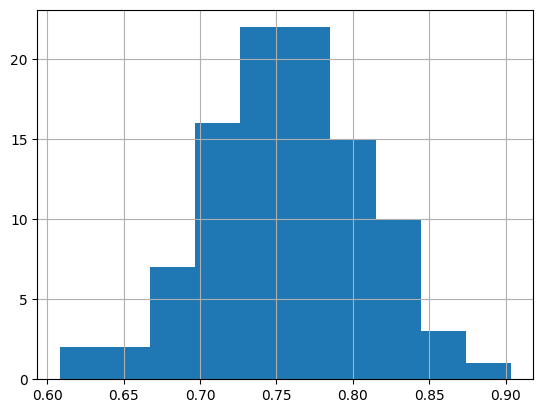

In [9]:
# plot disparate impact metric distribution
df_metrics[df_metrics['Metric']=='Disparate Impact'].Value.hist()